<a href="https://colab.research.google.com/github/SelinErcan/MachineLearning/blob/main/Kmeans_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import*
from numpy.linalg import svd
import numpy as np
import seaborn as sns; sns.set()  # for plot styling
from sklearn.datasets.samples_generator import make_blobs
import os
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from sklearn.preprocessing import StandardScaler
from nltk.cluster import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from scipy.spatial.distance import cityblock as manhattan_distance

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Part I: Apply PCA to MNIST Data

In [ ]:
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#this part creates nXn data from the data
print ("X_train shape     :",X_train.shape)

X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

pca = PCA(0.98)
X_pca = pca.fit_transform(X_train) 
print("Number of components before PCA  = " + str(X_train.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_)) 

print ("New X_train shape :",X_pca.shape)


X_train shape     : (60000, 28, 28)
Number of components before PCA  = 784
Number of components after PCA 0.98 = 261
New X_train shape : (60000, 261)


## Part II: Using PCA before Classification

In [ ]:
def infer_cluster_labels(assigned_labels, actual_labels):
    inferred_labels = {}

    cluster_table = confusion_matrix(actual_labels, assigned_labels) 
    cluster_table_df = pd.DataFrame(cluster_table, columns = ['C1','C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10'])
    print("\nCluster Table\n{}\n".format(cluster_table_df))

    for i in range(len(unique(assigned_labels))):

        # find index of points in cluster
        labels = []
        index = np.where(assigned_labels == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        print('Cluster: {} to label: {}'.format(i+1, np.argmax(counts)))
    
    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
  # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key

    return predicted_labels

In [ ]:
def k_means(X,y,distance_metric): #does random forest and k-fold cross validation.It also looks accuracy and confusion matrices

    total_iteration = 10
    
    training_scores = list()
    testing_scores = list()

    kf = KFold(n_splits=5)
    split=kf.get_n_splits(X)
    print("K-fold cross validation split:",split) 
    step = 1

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print("\n\n**************** {} ********************".format(step))

        print("\n--------------Training------------------")
        clusterer = KMeansClusterer(len(unique(y)), distance = distance_metric)
        cluster_labels = clusterer.cluster(X_train, True)

        cluster_labels = infer_cluster_labels(np.asarray(cluster_labels), y_train)
        X_clusters = []
        for vector in X_train:
            X_clusters.append(clusterer.classify(vector))
        X_clusters = np.asarray(X_clusters)

        predicted_labels = infer_data_labels(X_clusters, cluster_labels)

        conf_matrix = confusion_matrix(y_train, predicted_labels) #write confusion matrix
        df_cm = pd.DataFrame(conf_matrix)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, fmt=".1f") 
        plt.show()

        accuracy = accuracy_score(y_train, predicted_labels)  #calculate accuracy
        print("\nAccuracy: %",accuracy*100)
        print("\n")
        training_scores.append(accuracy*100)

        print("--------------Testing with 1-nn------------------")
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, predicted_labels)
        predicted_labels = knn.predict(X_test)

        conf_matrix = confusion_matrix(y_test, predicted_labels) #write confusion matrix
        df_cm = pd.DataFrame(conf_matrix)
        plt.figure(figsize = (10,7))
        sn.heatmap(df_cm, annot=True, fmt=".1f") 
        plt.show()

        accuracy = accuracy_score(y_test, predicted_labels)  #calculate accuracy
        print("\nAccuracy: %",accuracy*100)
        print("\n")
        testing_scores.append(accuracy*100)

        step += 1
        
        
    print('Mean Score of Training %s' % training_scores.mean())    
    print('Mean Score of Testing %s' % testing_scores.mean())   
    return [training_scores, testing_scores]

Result of K-Means Clustering with Eucledian Distance: 

K-fold cross validation split: 5


**************** 1 ********************

--------------Training------------------

Cluster Table
     C1    C2    C3    C4    C5    C6    C7    C8    C9   C10
0    16  1926   155   134   135    13    15    32  2275    16
1  5275     0    10    25     6    40     4     7     0    24
2   501   111   150   130   247  3387    52   152    11    41
3   314    97    47   785  3235   192    27    65    15   126
4   169    10   101    11     0    13  1273  1850     3  1228
5   602   211   100  1166  1506    14   328   180    48   218
6   346   113  3797    90    23    85     1   171    81     3
7   294    12     2     7     2    31  2121   518     7  1992
8   455    28    33  2767   948    49   182   101    29   132
9   139    13     6    39    71     6  1255  1264    22  1941

Cluster: 0 to label: 1
Cluster: 1 to label: 0
Cluster: 2 to label: 6
Cluster: 3 to label: 8
Cluster: 4 to label: 3
Cluster: 5 to 

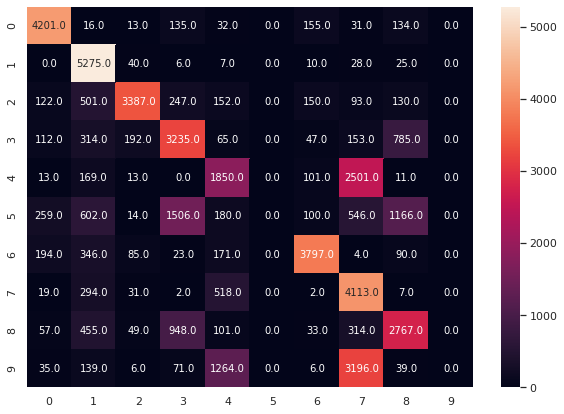


Accuracy: % 59.635416666666664


--------------Testing with 1-nn------------------


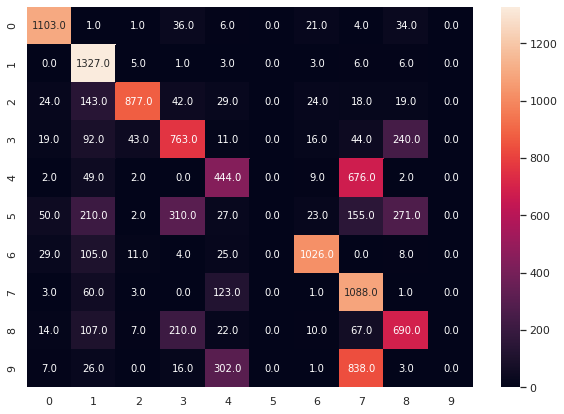


Accuracy: % 60.983333333333334




**************** 2 ********************

--------------Training------------------

Cluster Table
     C1    C2    C3    C4    C5    C6    C7    C8    C9   C10
0    32     2     4   134     2  3434   900    54   180     6
1     5  2902    11     5  2418     0     3     5     5     7
2   152   314    52    90   265    31   158   135   208  3382
3   139   314    34    28    40    17   380   764  3035   121
4  2523   130  1558   107   160     8   155    12     0    26
5   294   126   141    63   183    40  1332   737  1406     3
6    53   172     1  3195    30    47  1165    14    26    53
7  1406   285  3086     4   201    17    10    13     3    30
8   140   241   132    37   227    21   248  2798   803    39
9  2279   183  2019     5    65    29    20    52    65    14

Cluster: 0 to label: 4
Cluster: 1 to label: 1
Cluster: 2 to label: 7
Cluster: 3 to label: 6
Cluster: 4 to label: 1
Cluster: 5 to label: 0
Cluster: 6 to label: 5
Cluster: 7 to label: 8


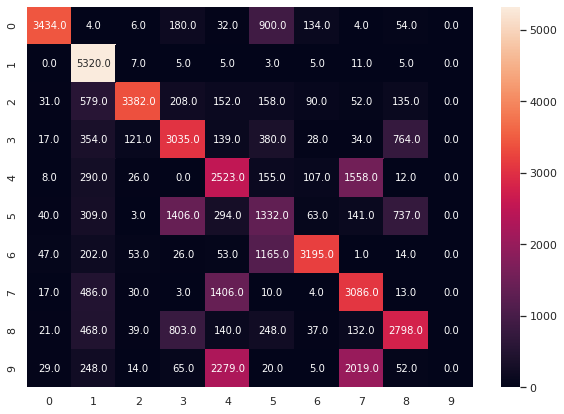


Accuracy: % 58.552083333333336


--------------Testing with 1-nn------------------


In [ ]:
print("Result of K-Means Clustering with Eucledian Distance: \n")
eucledian_scores = k_means(X_pca, y_train, euclidean_distance)

In [ ]:
print("Result of k-Means Clustering with Manhattan Distance: \n")
manhattan_scores = k_means(X_pca, y_train, manhattan_distance)

In [ ]:
print("Result of k-Means Clustering with Cosine Distance: \n")
cosine_scores = k_means(X_pca, y_train, cosine_distance)